<a href="https://colab.research.google.com/github/open-forest-observatory/stac/blob/main/scripts/STAC_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SpatioTemporal Asset Catalog (STAC) API
This notebook demonstrates the use of pystac_client python library to crawl through and access geospatial assets from Open Forest Observatory STAC compliant API. 

### Running this notebook on local machine
I recommend starting with a clean python environment. For example, you could create a new conda environment with a recent version of python.
`conda create --name stac_api_crawl python=3.12`

Then activate the environment:
`conda activate stac_api_crawl` 

Install ipykernel to use the new environment in Jupyter notebooks:
`pip install ipykernel`



In [ ]:
# Install required libraries for this notebook
!pip install pystac_client --quiet
!pip install geopandas --quiet
!pip install folium --quiet
!pip install rasterio --quiet
!pip install matplotlib --quiet

In [24]:
#Import the libraries into the current session

import pystac_client
import geopandas
import folium
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import requests
import numpy as np
import os

In [2]:
catalog = pystac_client.Client.open(
    "https://stac.cyverse.org"
)

In [3]:
#Let's look at the collections within the root catalog
collections = list(catalog.get_collections())

# Print the number of collections
print(f"Number of collections in the base catalog: {len(collections)}")

# Print the names (or IDs) and descriptions of each collection
for collection in collections:
    print(f"ID: {collection.id}")

Number of collections in the base catalog: 1
ID: Open Forest Observatory


In [4]:
#Search the collection to find the number of items

search = catalog.search(collections=["Open Forest Observatory"])
items = search.item_collection()
len(items)

321

In [5]:
###Show the collection boundaries and the item geometries on a map

# Create a base folium map centered on [0, 0] (change as desired) 
m = folium.Map(location=[0, 0], zoom_start=2)

# Loop over each collection and add bounding boxes
for coll in collections:
    for bbox in coll.extent.spatial.bboxes:
        # bbox is typically [west, south, east, north]
        west, south, east, north = bbox

        # Format into a list of lat/lon pairs in Leaflet-friendly order: [lat, lon]
        coords = [
            [south, west],
            [south, east],
            [north, east],
            [north, west],
            [south, west]
        ]

        # Create a polygon for this bbox and add it to the map
        folium.Polygon(locations=coords, fill=False).add_to(m)

# Example style function that returns a style dictionary
def style_function(feature):
    return {
        "color": "orange",         # the outline color for polygons/lines
        "weight": 3,            # line/polygon edge thickness
        "fillOpacity": 0.0,     # fill opacity (0.0 fully transparent -> 1.0 fully opaque)
    }

for item in items:
    # item.geometry should be a valid GeoJSON geometry 
    # (polygon, multipolygon, etc.)
    if item.geometry:
        # Directly add GeoJSON geometry
        folium.GeoJson(
            item.geometry,
            style_function=style_function,
            tooltip=f"Item ID: {item.id}"
        ).add_to(m)


# Show the map
m



In [6]:
#Create a custom spatial and temporal filter to find items of interest

time_range = "2023-01-01/2024-12-31"
bbox = [-123.621, 38.32, -119.67, 40.293] #SW corner longitude/latitude ; NE corner longitude/latitude

In [7]:
#Search the collection to find imagery assets within my time-range and bounding box.

search = catalog.search(collections=["Open Forest Observatory"], bbox=bbox, datetime=time_range)
items = search.item_collection()
len(items)



167

In [8]:
# Show the filtered search on the map
m = folium.Map(location=[0, 0], zoom_start=2)

for item in items:
    # item.geometry should be a valid GeoJSON geometry 
    # (polygon, multipolygon, etc.)
    if item.geometry:
        # Directly add GeoJSON geometry
        folium.GeoJson(
            item.geometry,
            style_function=style_function,
            tooltip=f"Item ID: {item.id}"
        ).add_to(m)

# Show the map
m


In [9]:
#Check if the 'platform' or 'license' properties are present in the items
search = catalog.search(
    collections=["Open Forest Observatory"],
    # Force the API to include all properties
    fields={
        "include": ["properties", "geometry", "bbox", "assets", "links"]
    }
)

items = list(search.item_collection())
print(f"Retrieved {len(items)} items total")

# Now check if 'platform' or 'license' appear
for item in items:
    print(item.id, item.properties.get("platform"), item.properties.get("license"))


Retrieved 321 items total
000918 eBee X CC-BY-SA-4.0
000917 eBee X CC-BY-SA-4.0
000916 eBee X CC-BY-SA-4.0
000915 eBee X CC-BY-SA-4.0
000914 eBee X CC-BY-SA-4.0
000913 eBee X CC-BY-SA-4.0
000931 Mavic 3 Multispectral CC-BY-SA-4.0
000930 Mavic 3 Multispectral CC-BY-SA-4.0
000929 Mavic 3 Multispectral CC-BY-SA-4.0
000928 Mavic 3 Multispectral CC-BY-SA-4.0
000927 Mavic 3 Multispectral CC-BY-SA-4.0
000926 Matrice 300 CC-BY-SA-4.0
000925 Matrice 300 CC-BY-SA-4.0
000924 Matrice 300 CC-BY-SA-4.0
000923 Matrice 300 CC-BY-SA-4.0
000922 Matrice 300 CC-BY-SA-4.0
000921 Matrice 300 CC-BY-SA-4.0
000920 Matrice 300 CC-BY-SA-4.0
000919 Matrice 300 CC-BY-SA-4.0
000912 eBee X CC-BY-SA-4.0
000911 eBee X CC-BY-SA-4.0
000910 eBee X CC-BY-SA-4.0
000909 eBee X CC-BY-SA-4.0
000908 eBee X CC-BY-SA-4.0
000630 Evo II v2 CC-BY-SA-4.0
000629 Matrice 300 CC-BY-SA-4.0
000628 Matrice 300 CC-BY-SA-4.0
000627 Matrice 300 CC-BY-SA-4.0
000626 Matrice 300 CC-BY-SA-4.0
000625 Matrice 300 CC-BY-SA-4.0
000624 Matrice 300 CC

In [10]:
# Filter locally for items that match the platform
platform_of_interest = "eBee X"
filtered_items = [
    item for item in items 
    if item.properties.get("platform") == platform_of_interest
]

print(f"Found {len(filtered_items)} items with platform == '{platform_of_interest}':")

# Print info on the filtered items
for item in filtered_items:
    print(item.id, item.properties.get("platform"), item.properties.get("license"))

Found 20 items with platform == 'eBee X':
000918 eBee X CC-BY-SA-4.0
000917 eBee X CC-BY-SA-4.0
000916 eBee X CC-BY-SA-4.0
000915 eBee X CC-BY-SA-4.0
000914 eBee X CC-BY-SA-4.0
000913 eBee X CC-BY-SA-4.0
000912 eBee X CC-BY-SA-4.0
000911 eBee X CC-BY-SA-4.0
000910 eBee X CC-BY-SA-4.0
000909 eBee X CC-BY-SA-4.0
000908 eBee X CC-BY-SA-4.0
000618 eBee X CC-BY-SA-4.0
000617 eBee X CC-BY-SA-4.0
000616 eBee X CC-BY-SA-4.0
000615 eBee X CC-BY-SA-4.0
000614 eBee X CC-BY-SA-4.0
000562 eBee X CC-BY-SA-4.0
000561 eBee X CC-BY-SA-4.0
000560 eBee X CC-BY-SA-4.0
000559 eBee X CC-BY-SA-4.0


In [11]:
# Show the filtered search on the map
m = folium.Map(location=[0, 0], zoom_start=2)

for item in filtered_items:
    # item.geometry should be a valid GeoJSON geometry 
    # (polygon, multipolygon, etc.)
    if item.geometry:
        # Directly add GeoJSON geometry
        folium.GeoJson(
            item.geometry,
            style_function=style_function,
            tooltip=f"Item ID: {item.id}"
        ).add_to(m)

# Show the map
m

In [ ]:
# Define function to print STAC item info

def print_item_info(item_id, items):
    """
    Given an item_id and a list of pystac.Item objects, find the matching item
    and print details including datetime, license, platform, and asset info.
    """
    # 1. Look up the item in the list by item_id
    item = next((i for i in items if i.id == item_id), None)
    if not item:
        print(f"No item found with ID: {item_id}")
        return

    # 2. Print main properties from the item
    print(f"Item ID: {item.id}")
    print(f"  Datetime: {item.properties.get('datetime')}")
    print(f"  License: {item.properties.get('license')}")
    print(f"  Platform: {item.properties.get('platform')}")

    # 3. Print details about each asset
    print("\nAssets:")
    for asset_key, asset in item.assets.items():
        # The typical fields:
        media_type = asset.media_type
        href = asset.href

        # 'proj:epsg' and 'gsd' often appear in STAC extensions, so we look them up:
        #   - If they don't exist, this returns None.
        epsg = asset.extra_fields.get("proj:epsg")
        gsd = asset.extra_fields.get("gsd")

        print(f"  Asset key: {asset_key}")
        print(f"    type: {media_type}")
        print(f"    href: {href}")
        print(f"    proj:epsg: {epsg}")
        print(f"    gsd: {gsd}")


In [16]:
print_item_info("000143", items)

Item ID: 000143
  Datetime: 2023-07-06T11:41:22+00:00
  License: CC-BY-SA-4.0
  Platform: Mavic 3 Multispectral

Assets:
  Asset key: points
    type: application/vnd.laszip+copc
    href: https://data.cyverse.org/dav-anon/iplant/home/shared/ofo/public/missions/000143/processed-20240502T2346/full/points.laz
    proj:epsg: 3310
    gsd: None
  Asset key: chm-mesh
    type: image/tiff; application=geotiff; profile=cloud-optimized
    href: https://data.cyverse.org/dav-anon/iplant/home/shared/ofo/public/missions/000143/processed-20240502T2346/full/chm-mesh.tif
    proj:epsg: 3310
    gsd: 0.25
  Asset key: dsm-mesh
    type: image/tiff; application=geotiff; profile=cloud-optimized
    href: https://data.cyverse.org/dav-anon/iplant/home/shared/ofo/public/missions/000143/processed-20240502T2346/full/dsm-mesh.tif
    proj:epsg: 3310
    gsd: 0.378
  Asset key: images_zip
    type: image/jpeg
    href: https://data.cyverse.org/dav-anon/iplant/home/shared/ofo/public/missions/000143/images/imag

In [17]:
cog_path = "https://data.cyverse.org/dav-anon/iplant/home/shared/ofo/public/missions/000143/processed-20240502T2346/full/dsm-mesh.tif"

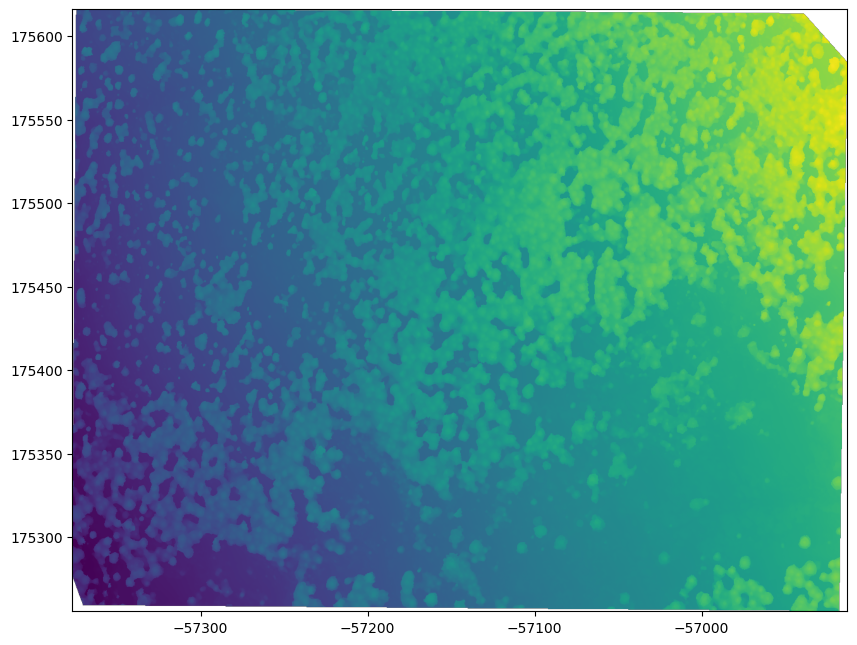

In [20]:
##Read in and display the entire COG. Large files require a lot of memory usage.

with rasterio.open(cog_path) as dataset:
    # Read the entire dataset
    # This reads all bands; if the dataset is multi-band, they will be read into a 3D array
    data = dataset.read()

    # Display the image
    # For simplicity, this example displays the first band.
    plt.figure(figsize=(10, 10))
    show(data[0], transform=dataset.transform)

In [ ]:
#Download the COG to a local directory

cog_path = "https://data.cyverse.org/dav-anon/iplant/home/shared/ofo/public/missions/000143/processed-20240502T2346/full/dsm-mesh.tif"

download_dir = "/home/jgillan/Downloads"  

In [ ]:
# Define a function to download a COG

def download_cog(cog_path, download_dir):
    """
    Downloads a COG from `cog_path` into `download_dir`, retaining its original filename.
    """
    # 1) Make sure the download directory exists
    os.makedirs(download_dir, exist_ok=True)

    # 2) Extract the filename from the URL
    filename = os.path.basename(cog_path)  # e.g. "myfile.tif"

    # 3) Create the full path to the file we will write
    out_path = os.path.join(download_dir, filename)

    # 4) Perform the GET request (with streaming, if you have large files)
    response = requests.get(cog_path, stream=True)

    # 5) Check for success and then write in chunks
    if response.status_code == 200:
        with open(out_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print(f"COG downloaded successfully: {out_path}")
    else:
        print(f"Failed to download COG from {cog_path}. Status code: {response.status_code}")


# Call the download function
download_cog(cog_path, download_dir)


COG downloaded successfully: /home/jgillan/Downloads/dsm-mesh.tif
